In [4]:
import torch
from mano.manolayer import ManoLayer

ncomps = 45
mano_layer = ManoLayer(mano_root='./mano/models', use_pca=False, ncomps=ncomps, flat_hand_mean=True)

# poses = torch.rand(1, ncomps + 3, dtype=torch.float32)
# poses = torch.zeros(1, ncomps + 3, dtype=torch.float32)
poses = torch.tensor([0, 0, 0, 0.11167872, 0.04289217, -0.41644184, 0.10881133, -0.06598568, -0.75622001,
 -0.09639297, -0.09091566, -0.18845929, -0.11809504, 0.05094385, -0.5295845,
 -0.14369841, 0.0552417, -0.70485714, -0.01918292, -0.09233685, -0.33791352,
 -0.45703298, -0.19628395, -0.62545753, -0.21465238, -0.06599829, -0.50689421,
 -0.36972436, -0.06034463, -0.07949023, -0.14186969, -0.08585263, -0.63552826,
 -0.30334159, -0.05788098, -0.63138921, -0.17612089, -0.13209308, -0.37335458,
  0.85096428, 0.27692274, -0.09154807, -0.49983944, 0.02655647, 0.05288088, 
  0.53555915, 0.04596104, -0.27735802], dtype=torch.float32)
poses = poses.unsqueeze(0)
poses = -poses
# poses[0][11] = -1.5
# poses[0][20] = 1.5
# poses[0][11] = 1.0
shapes = torch.zeros(1, 10, dtype=torch.float32)

vertices, joints, joint_trans_mat = mano_layer(poses, shapes)

# vertices = vertices[0] * 20
# joints = joints[0] * 20
joint_trans_mat = joint_trans_mat[0]
# joint_trans_mat = joint_trans_mat.permute(2, 0, 1)
# joint_trans_mat[:, :3, 3] *= 20

# print(vertices)
print(joint_trans_mat[:, :, 3])


tensor([[ 0.2208, -0.9750,  0.0254, -0.0181],
        [ 0.9366,  0.2192,  0.2735,  0.0067],
        [-0.2722, -0.0366,  0.9615, -0.0088],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

def display_hand(hand_info, mano_faces=None, ax=None, alpha=0.2, batch_idx=0, show=True):
    """
    Displays hand batch_idx in batch of hand_info, hand_info as returned by
    generate_random_hand
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    verts, joints = hand_info['verts'][batch_idx], hand_info['joints'][
        batch_idx]
    if mano_faces is None:
        ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], alpha=0.1)
    else:
        mesh = Poly3DCollection(verts[mano_faces], alpha=alpha)
        face_color = (141 / 255, 184 / 255, 226 / 255)
        edge_color = (50 / 255, 50 / 255, 50 / 255)
        mesh.set_edgecolor(edge_color)
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color='r')
    cam_equal_aspect_3d(ax, verts.numpy())
    if show:
        plt.show()


def cam_equal_aspect_3d(ax, verts, flip_x=False):
    """
    Centers view on cuboid containing hand and flips y and z axis
    and fixes azimuth
    """
    extents = np.stack([verts.min(0), verts.max(0)], axis=1)
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    if flip_x:
        ax.set_xlim(centers[0] + r, centers[0] - r)
    else:
        ax.set_xlim(centers[0] - r, centers[0] + r)
    # Invert y and z axis
    ax.set_ylim(centers[1] + r, centers[1] - r)
    ax.set_zlim(centers[2] + r, centers[2] - r)

path = './'

def toObj(vertices, faces, filename='hand.obj', normalize=True):
    if normalize:
        min_x = min(vertices[:, 0])
        max_x = max(vertices[:, 0])
        min_y = min(vertices[:, 1])
        max_y = max(vertices[:, 1])
        min_z = min(vertices[:, 2])
        max_z = max(vertices[:, 2])

        scale = max(max_x - min_x, max_y - min_y, max_z - min_z)

        vertices[:, 0] = (vertices[:, 0] - min_x) * 2 / scale - 1.
        vertices[:, 1] = (vertices[:, 1] - min_y) * 2 / scale - 1.
        vertices[:, 2] = (vertices[:, 2] - min_z) * 2 / scale - 1.

    with open(path + filename, 'w') as f:
        for v in vertices:
            f.write('v %f %f %f\n' % (v[0], v[1], v[2]))

        for face in faces:
            f.write('f %d %d %d\n' % (face[0] + 1, face[1] + 1, face[2] + 1))

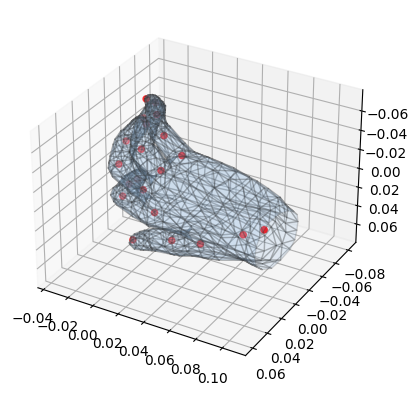

In [5]:
display_hand(
    {'verts': vertices,
    'joints': joints},
    mano_faces=mano_layer.th_faces,
)

toObj(vertices[0] * 12, mano_layer.th_faces, filename='hand_test.obj', normalize=False)

In [5]:
from mano.deformation import warp_observation_to_canonical

points = torch.rand(10, 3, dtype=torch.float32)
faces = mano_layer.th_faces
weights = mano_layer.th_weights
trans_mat = warp_observation_to_canonical(points, vertices, faces, joint_trans_mat, weights)

tensor([[0.1229, 0.3398, 0.0576],
        [0.9003, 0.1646, 0.2053],
        [0.3359, 0.3506, 0.7485],
        [0.6307, 0.6624, 0.7544],
        [0.5571, 0.9245, 0.5297],
        [0.1857, 0.2802, 0.6982],
        [0.3327, 0.0592, 0.1903],
        [0.3237, 0.3009, 0.2678],
        [0.3175, 0.5932, 0.2298],
        [0.1738, 0.1244, 0.8506]])
torch.Size([10, 16])
tensor([[[ 6.1896e-01,  8.3198e-01,  3.6130e-01,  3.7144e-01],
         [-3.0656e-01, -2.6928e-01,  1.0553e+00,  5.4296e-02],
         [ 7.6307e-01, -7.1960e-01, -8.2407e-03, -9.6040e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 8.4648e-01,  4.2558e-01, -3.2361e-01,  2.8100e-01],
         [-5.7475e-03,  6.1316e-01,  7.9179e-01, -4.0685e-02],
         [ 5.3318e-01, -6.6747e-01,  5.2042e-01, -8.7604e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 8.6077e-01,  5.0701e-01, -2.7969e-01,  2.8524e-01],
         [-6.0162e-02,  5.7470e-01,  8.7000e-01, -6.1684e-02],
    

In [14]:
print(np.cos(1))

0.5403023058681398
